<a href="https://colab.research.google.com/github/vallematteo/Computational-Finance-Course-Lech-Grzelach/blob/main/heston_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Calibration: an introduction to three possibilities

Calibration is the most important inverse problem in finance and insurance: we search for models which explain current price structures in the market, in contrast to econometric models which explain the dynamics of prices. Of course it is desirable to unify these approaches, which, however, is a still a challenging task.

Let us first introduce the problem. We have a pool of models $\Theta$, which is parameterized by parameter vector $ \theta \in \Theta $, and we have prices of financial products, which can be calculated for a given parameter $ \theta $. Take for instance the Black-Scholes model, where the parameter vector $ \theta = (S_0,\sigma,r) $ consists of today's price $S_0$, a volatility parameter $ \sigma $ and an interest rate $ r $. Prices of financial products could be calculated for any path-dependent European or American option.

Given a such a pool of a models, a price structure which can be calculated given a model $ \theta \in \Theta $ and a price structure from real markets, the market price structure (later always referred to as \emph{data}), what is the most appropriate model to choose. \emph{Most appropriate} has to be specified by a loss function 
$$\theta \mapsto L^\mathrm{data} (\theta) $$
which measures the distance of the model price structure to the market price structure.

Whence we are interested in minimizing $\theta \mapsto L^\mathrm{data}(\theta)$ for $ \theta \in \Theta$. The calculation of possible minimizers $ \theta^*$ is called \emph{calibration (problem)}. It is a typical example of an inverse problem, which we have already encountered in the lecture about training. In this setting we do neither develop a theory of regularization, as we have done in the lecure about training, nor do we look into Bayesian approaches, but we rather focus on particular features manifest in calibration problems.

1. In typical pricing models (SDE models of affine type, models with easy to evaluate characteristics, etc) it is often relatively easy to evaluate $L^\mathrm{data}(\theta)$ for a given parameter $ \theta \in \Theta $. Models, where this evaluation is difficult, have been rarely used in industry, for instance dynamic models for implied volatility surfaces or rough volatility models. Still some computational effort lies in this procedure and often only models are used where actually the loss function can be easily evaluated.

2. Even if it is easy to evaluate the loss function given data, the inverse problem is often high dimensional and a high accuracy is desired, i.e. the loss has to be really small. This is in contrast to inverse problems which appear in training where it is often not a priori clear which loss is desirable.

3. Regularization might complicate the problem considerably.

From a machine learning perspective there are three approaches which one could try in such a setting:

1. (ambitious approach) learn the map
$$
\text{ data } \mapsto \theta^*
$$
   directly. If it works it is of course a   wonderful tool, but one needs to be aware that one learns a possibly quite irregular map (if no explicit regularization has been used).

2. (modest approach) learn the map
$$
\theta \mapsto \text{ data }
$$
which is relatively easy to generate and often quite regular. Next solve the inverse problem by replacing the pricing functional through its learned approximation.

3. (neural model approach) take a modelling approach which includes neural networks right away and learn those models to perform respective tasks. In other words enter new modelling paradigms.

# Deep Calibration: learn the inverse map directly

This approach has been successfully applied, for instance, by Andres Hernandez in a paper called [Model calibration with   neural networks](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2812140). There a Hull-white extended Vasicek model is calibrated to market data consisting of yield curve data and ATM swaptions by a direct machine learning technology. A report on an extension of this approach can be found in the [talk from a conference in Budapest](https://people.math.ethz.ch/~jteichma/talk_budapest.pdf).

# Deep Calibration: Heston model calibration by machine learning the pricing functional

The following code is part of Matteo Gambara's PhD thesis project.

The purpose of the code is to train a neural network to approximate the map from the parameters of the model to implied volatility, to have a fast and efficient calibration tool. Notice that this first attempt to do calibration by machine learning techniques is theoretically well founded: the map
$$
\text{ parameter } \mapsto \text{ prices }
$$
is usually very regular (often smooth) and can be learned on randomly sampled subsets (usually the parameter space is a linear space). Then the trained network is used for the formulation of the inverse problem.

The code heavily relies on [QuantLib](https://www.quantlib.org), which is an open-source library for quantitative finance.

The set of parameters we try to calibrate is $\Theta = \{\theta, \kappa, \sigma, \rho\}$. All parameters are splitted into two sets: the "observables" are the spot price $S_0$, the interest rate and dividend yields $r$, $q$ respectively, and $v_0$, the initial variance of the Heston model; the "model parameters" are those contained in $\Theta$.

The model reads as follows:
$$
d X_t = ((q-r) -Y_t/2)  dt + \sqrt{Y_t} dW^1_t, \; dY_t = (\theta - \kappa Y_t) dt + \sigma \sqrt{Y_t} dW^2_t 
$$
where $ X_0 = \log (S_0) $ and $ Y_0 = v_0 $.

The set of maturities and strikes is fixed a priori. For this reason, these parameters are not given as input to the NN.

In [ ]:
!pip install QuantLib

# Import packages
from __future__ import division
import pandas as pd
import numpy as np
import datetime as dt

import QuantLib as ql
# This controls whether functionEvaluation is available in QuantLib library
has_function_evals = True
float_type = np.float32

from itertools import product
import matplotlib.pyplot as plt
import pickle
import os
data_dir = os.getcwd()

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from scipy.stats import norm

     |████████████████████████████████| 18.8MB 202kB/s 


In [ ]:
# Calendar conventions
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
# Option conventions
moneyness = [.8, .85, .9, .95, .975, .99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.15, 1.2] # S_0/K 
delta_times = [15, 30, 45, 60, 90, 120, 180, 240, 300, 360, 420]

'''
Dictionary defining model
It requires 3 parameters:
    -name
    -process
    -model: a function that creates a model. It takes as parameter a 
            yield curve handle
    -engine: a function that creates an engine. It takes as paramters a
            calibration model and a yield curve handle
    -option_type            
Optional parameters:
    -transformation: a preprocessing function
    -inverse_transformation: a postprocessing function
'''
he_analytic = {'name' : 'Heston',
               'process' : ql.HestonProcess,
               'model' : ql.HestonModel, 
               'engine' : ql.AnalyticHestonEngine,
               'option_type' : ql.Option.Call,
               'transformation' : np.log, 
               'inverse_transformation' : np.exp}

In [ ]:
# Helper functions
def create_imp_vol_skeleton(strike_struct, expiration_dates_struct, 
                            calculation_date, spot_price):
    '''
    Create the structure (skeleton) on which it is possible to price all options.
    '''
    strikes = [spot_price/m for m in strike_struct]
    expiries = [calculation_date+d_time for d_time in expiration_dates_struct]
    ttm_days = [(d-calculation_date) for d in expiries] # time to maturity
    ttm_year = [day_count.yearFraction(calculation_date, d) for d in expiries]
    
    new_array = np.array((ttm_days,strikes))
    cartesian_product_vola_surface = list(product(*new_array))
    df = pd.DataFrame(cartesian_product_vola_surface, 
                        columns=['ttm','strikes'])
    return strikes, np.array((ttm_year)), expiries, df

def set_risk_free_rate(calculation_date, risk_free_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,risk_free_rate,day_count))

def set_dividend_rate(calculation_date, dividend_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,dividend_rate,day_count))

def set_spot(spot_price):
    return ql.QuoteHandle(ql.SimpleQuote(spot_price))

def create_european_option(calculation_date, opt_type, strike_price, ttm):
    # Create European options
    payoff = ql.PlainVanillaPayoff(opt_type, strike_price)
    maturity = calculation_date+int(ttm)
    exercise = ql.EuropeanExercise(maturity)
    return ql.VanillaOption(payoff, exercise)

## Heston model class

The following class is used to produce an object of type Heston_Model. Every object of this type has its own attributes: observables and model parameters.

Every object has also a dataframe associated, called "df", which contains all the prices of the options linked to the fixed strikes and maturities.

The input of the class are a dictionary with some general information (QuantLib commands to generate Heston prices, type of options, etc...) and the parameters discussed above.

In [ ]:
class Heston_Model:
    def __init__(self, model_dict, spot_price=100., risk_free_rate=0.01, dividend_rate=0.0,
                 inst_var=0.1, calculation_date=ql.Date(8,11,2015),  
                 expiration_dates_struct=delta_times, strike_struct=moneyness,
                 mean_rev_speed=None, eq_var=None, vol_of_vol=None, correlation=None):
        '''
        This class implements the Heston model for a series of given parameters.
        The output will be a dataframe where the columns are parameters, strikes
        time_to_maturities, prices and values of the volatility surface.
        '''
        self._model_dict = model_dict
        if ('process' not in self._model_dict 
            or 'model' not in self._model_dict
            or 'engine' not in self._model_dict
            or 'name' not in self._model_dict
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        
        self.option_type = self._model_dict['option_type']
        self.calculation_date = calculation_date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        #heston model parameters
        self.nb_params = 4
        self.sigma = vol_of_vol
        self.rho = correlation
        self.theta = eq_var
        self.kappa = mean_rev_speed
        self.heston_param = np.array((self.kappa,self.theta,self.sigma,self.rho))
        
        # volatility surface structure
        self.strikes, self.ttm, self.expiries, self.df = create_imp_vol_skeleton(
                                    strike_struct, expiration_dates_struct, 
                                    calculation_date, spot_price)
        
        # Yield curve, dividends, spot and instantaneous volatility
        self.risk_free_rate = risk_free_rate
        self.dividend_rate = dividend_rate
        self.spot_price = spot_price
        self.v0 = inst_var
        
        self.ircurve = set_risk_free_rate(self.calculation_date, self.risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, self.dividend_rate)
        self.spot = set_spot(self.spot_price)
        
        process = self.__create_process(self.kappa,self.theta,self.sigma,self.rho)
        model = self._model_dict['model'](process)
        engine = self._model_dict['engine'](model)
        
        eu_options = [create_european_option(self.calculation_date,self.option_type,s,t) 
                   for s,t in zip(self.df['strikes'], self.df['ttm'])]
        [opt.setPricingEngine(engine) for opt in eu_options]
        self.df['price'] = [o.NPV() for o in eu_options]
#        self.df['analytical_price'] = self.df['price'][:] #####

    def __create_process(self,kappa,theta,sigma,rho):
        # Creation of the object Process
        return self._model_dict['process'](self.ircurve,self.dividend,self.spot,
                self.v0,kappa,theta,sigma,rho)

In [ ]:
# Helper functions for the class HestonGroup
def datetime_to_ql(d):
    return ql.Date(d.day,d.month,d.year)

def ql_to_datetime(dateql):
    return dt.datetime(dateql.year(), dateql.month(), dateql.dayOfMonth())

def ql_to_datetime_settings_dict(dates_ql, dictionary):
    if bool(dictionary):
        for dateql in dates_ql:
            helper = ql_to_datetime(dateql)
            dictionary[helper]=dictionary.pop(dateql)                                                                
                
def datetime_to_ql_settings_dict(dates, dictionary):
    if bool(dictionary):
        dates = sorted(dates)
        for date in dates:
            helper = date_to_ql(date)
            dictionary[helper] = dictionary.pop(date)
            
def save_dictionary(dictionary, name_dict, path=data_dir):
        filehandler = open(path+ '/' +name_dict+'.pkl','wb')
        pickle.dump(dictionary,filehandler)
        filehandler.close()

def load_dictionary(name_dict, path=data_dir):
        with open(path+ '/' +name_dict+'.pkl', 'rb') as handle:
            dictionary = pickle.load(handle)
        return dictionary

In [ ]:
# Bounds for the calibration of the parameters (in implied_vola_generation.py)
he_generation_bounds = [(0.5,10.), (0.05,0.8), (0.05,0.8), (-0.99,0.99)] #kappa,theta,sigma,rho
he_calibration_bounds = [(0.001,15.), (0.001,6.), (0.005,4.), (-0.999,0.999)]
he_mean_as_initial_point = [5., 1.5, 1., 0.]

In [ ]:
# Function to plot the volatility surface
def plot_surface(Z, z_label, main_title, string1='', string2='', W=None, string3='', **kwargs):
    times = kwargs.get('delta_times', delta_times)
    money = kwargs.get('moneyness', moneyness)
    X = times; Y = money
    X, Y = np.meshgrid(X, Y)
    X = np.transpose(X); Y = np.transpose(Y)
    if Z.shape != (X.shape[0],Y.shape[1]):
        Z = Z.reshape((len(times),len(money)))
    if W is not None and W.shape != (X.shape[0],Y.shape[1]):
        W = W.reshape((len(times),len(money)))
    
    if W is None:
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        fig.suptitle(main_title)
        plt.show()
    else:
# COMMENT IF MAYAVI NOT AVAILABLE
#        from mayavi import mlab
#        fig = mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,600))
#        ax_ranges = [min(times), max(times), min(money), max(money), 0, max(np.amax(Z),np.amax(W))]
#        surf3 = mlab.surf(X, Y, Z, colormap='Oranges', warp_scale='auto')
#        surf4 = mlab.surf(X, Y, W, colormap='Blues', warp_scale='auto')
#        cb1 = mlab.colorbar(object=surf3, title='Original IVS', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#Original
#        cb2 = mlab.colorbar(object=surf4, title='Neural net 1', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#NN1
#        cb1.scalar_bar_representation.position = [0.12, 0.15] #bottom left
#        cb1.scalar_bar_representation.position2 = [0.1, 0.8] # from position!!!
#        cb2.scalar_bar_representation.position = [0.01, 0.15] #bottom left
#        cb2.scalar_bar_representation.position2 = [0.1, 0.8]
##        mlab.view(60, 74, 17, [-2.5, -4.6, -0.3])
#        ax = mlab.axes(surf3, color=(.7, .7, .7), #extent=ax_extent,
#                       ranges=ax_ranges, xlabel='time to maturity (days)', 
#                       ylabel='moneyness (%)', zlabel=z_label, nb_labels=5)
#        ax.axes.font_factor=0.8
#        title = mlab.title(main_title)
#        title.x_position = 0.3
#        title.y_position = 0.8
#        title.width = 0.5
#        print(title.__dict__)
#        mlab.show()
# UNCOMMENT IF MAYAVI NOT AVAILABLE        
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.Oranges, linewidth=0, antialiased=True, alpha=0.2)
        surf2 = ax.plot_surface(X, Y, W, cmap=cm.Blues, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        fig.colorbar(surf2, shrink=0.6, aspect=20, ax=ax)
        ax.text2D(0.15, 0.96, string3, transform=ax.transAxes)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        fig.suptitle(main_title)
        plt.show()

In [ ]:
'''
 - Search for the implied volatility - 
Since the differential evolution algorithm is extremly long, I have to use
another method to derive the implied volatility for option prices.
References are Li and Lee (2011) and Stefanica and Radoicic (2017).
'''

def approx_func(x):
    return 0.5 + 0.5*np.sign(x)*np.sqrt(1. - np.exp(-2.*(x**2)/np.pi))

def guess_StefanicaRadoicic(option_type, strike, option_price, spot_price,
                            ir_discount, dr_discount):
    
    forward = spot_price * dr_discount / ir_discount
    ey = forward/strike #ey=exp(y)
    emy = strike/forward #emy=exp(-y)
    y = np.log(ey)
    alpha = option_price/(strike*ir_discount)
    
    if option_type==1:
        #Call
        R = 2.*alpha - ey + 1.
    else:
        #Put
        R = 2.*alpha + ey - 1.
    pi_term = 2./np.pi
    arg_exp_term = (1.-pi_term)*y
    R2 = R**2
    
    a = np.exp(arg_exp_term)
    A = (a - 1./a)**2
    b = np.exp(pi_term*y)
    B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
    C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
    beta = 2.*C / (B + np.sqrt(B**2 + 4.*A*C))
    gamma = - np.pi/2.*np.log(beta)
    
    if y>=0.:
        if option_type==1: #call
            O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
        else:
            O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
        if option_price <= O0:
            nu = np.sqrt(gamma+y) - np.sqrt(gamma-y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    else:
        if option_type==1: #call
            O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
        else:
            O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
        if option_price <= O0:
            nu = np.sqrt(gamma-y) - np.sqrt(gamma+y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    return nu

def Phi(x,nu):
    nu2 = nu**2
    abs_term = 2.*np.abs(x)
    return (nu2-abs_term)/(nu2+abs_term)
def N_plus(x,nu):
    return norm.cdf(x/nu + 0.5*nu)
def N_minus(x,nu):
    return np.exp(-x)*norm.cdf(x/nu - 0.5*nu)
def F(nu, x, c_star, omega):
    return c_star + N_minus(x,nu) + omega*N_plus(x,nu)
def G(nu, x, c_star, omega):
    argument = F(nu, x, c_star, omega)/(1.+omega)
    term = norm.ppf(argument)
    return term + np.sqrt(term**2 + 2.*np.abs(x))
    
def SOR_TS(option_type, strike, discount_ir, discount_dr, option_price, 
                     spot_price, guess, omega, accuracy, max_iterations=20):
    
    assert (option_price >= 0.),'Price must be positive.'
    
    forward = spot_price * discount_dr / discount_ir
    x = np.log(forward/strike)
    
    if option_type==1:  #call
        c = option_price/(spot_price*discount_dr)
    else:   #put
        c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
    if x > 0.:
        # formula in-out duality
        c = c*forward/strike + 1. - forward/strike
        assert (c >= 0.),'Normalized price must be positive.'
        x = -x
    
    if not guess:
        guess = guess_StefanicaRadoicic(option_type, strike, option_price, 
                                       spot_price, discount_ir, discount_dr)
    assert (guess >= 0.),'Initial guess must be positive.'
    
    nIter = 0
    nu_k = nu_kp1 = guess
    difference = 1.
    while (np.abs(difference)>accuracy and nIter<max_iterations):
        nu_k = nu_kp1
        alpha_k = (1.+omega)/(1.+Phi(x,nu_k))
        nu_kp1 = alpha_k*G(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
        difference = nu_kp1 - nu_k
        nIter +=1
    return nu_kp1

# VolaSurface Class

The purpose of this class is to get as input the observable parameters and the data frame df with all the prices (listed by strike and maturity) and use these as input for the computation of the implied volatility.

In [ ]:
def return_year_fraction(date, ttm):
    return [day_count.yearFraction(date,date+int(nd)) for nd in ttm]

class VolaSurface:
    '''
    This class takes in input some prices and transform them in a volatility surface.
    '''
    def __init__(self, option_type, spot_price=100, risk_free_rate=0.01, dividend_rate=0.0,
                 calculation_date=ql.Date(8,11,2015), df=None):   
        # Main data structure
        self.data = df

        # Check to see if there are the correct columns        
        if not 'ttm' in self.data.columns \
        or not 'strikes' in self.data.columns \
        or not 'price' in self.data.columns:
            raise RuntimeError('Some necessary data is missing')
        
        # Option type, calculation date
        self.option_type = option_type
        self.calculation_date = calculation_date #already a ql Date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        # Yield curve, dividends, spot
        self.ircurve = set_risk_free_rate(self.calculation_date, risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, dividend_rate)
        self.spot = set_spot(spot_price)
        
        # Tolerance on implied volatility error
        self.tol = 1.e-14
    

    def __implied_vola(self, price, strike, ttm):
        # Find the implied volatility through other algorithms
        discount_ir = self.ircurve.discount(self.calculation_date+int(ttm))
        discount_dr = self.dividend.discount(self.calculation_date+int(ttm))
        sol = 0.0
        try:
            sol = SOR_TS(self.option_type, strike, discount_ir, discount_dr,
                         price, self.spot.value(), guess=None, 
                         omega=1., accuracy=self.tol)
        except (RuntimeWarning, AssertionError) as e:
            print(repr(e))
        yearly_ttm = day_count.yearFraction(self.calculation_date, self.calculation_date+int(ttm))
        sol = sol/np.sqrt(yearly_ttm)
        return sol
        
        
    def get_implied_vola(self):
        ivs = []
        for i in range(len(self.data['price'])):
            ivs.append(self.__implied_vola(self.data['price'][i],
                                           self.data['strikes'][i],
                                           self.data['ttm'][i]))
            if ivs[i]==0.:
                raise ValueError('Zero implied volatility!')
        return ivs

## HestonGroup Class

This class is a collection of Heston model objects. Every object is accessible through dictionaries whose keys are dates. The idea is that for every different day, I have a different model/object to calibrate.

In [ ]:
class HestonGroup:
    
    def __init__(self, model_dict=he_analytic, first_date=ql.Date(1,1,2018), 
                 end_date=ql.Date(2,1,2018)):
        #Create a collection of object of type Heston_Model
        self._model_dict = model_dict
        if ('model' not in self._model_dict
            or 'process' not in self._model_dict
            or 'engine' not in self._model_dict 
            or 'name' not in self._model_dict 
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        self.model_name = self._model_dict['name'].replace("/", "").lower()
        
        # Option type
        self.option_type = self._model_dict['option_type']
        # Dates
        self.dates = pd.date_range(ql_to_datetime(first_date), ql_to_datetime(end_date))
        #print(self.dates)
        # in this way I generate a date for every day (with holidays)
        self.dates_ql = [datetime_to_ql(d) for d in self.dates]
        #print(self.dates_ql)
        
        # Dictionaries
        self.he_observable = {} #contains s0, ir, dr and v0
        self.he_hist_parameters = {} #contains s0, ir, dr + 5 heston params
        self.he_hist_df = {} #contains the entire data_frame with ttm, strikes, prices
        self.he_hist_iv = {} #contains the implied vola surface given by the data_frame
        
        
    # Methods for the generation of the fake volatility surfaces
    def __generate_ir(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.08)
    def __generate_dr(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.03)
    def __generate_sp(self):
        return 100*(np.random.beta(a=8, b=8) + 1.0E-2)
    def __generate_theta(self):
        return np.random.uniform(low=he_generation_bounds[1][0], high=he_generation_bounds[1][1])
    def __generate_v0(self):
        return np.random.uniform(low=0.001, high=0.9)**2
    def __generate_rho(self):
        return np.random.uniform(low=he_generation_bounds[3][0], high=he_generation_bounds[3][1])
    def __generate_kappa(self):
        return np.random.uniform(low=he_generation_bounds[0][0], high=he_generation_bounds[0][1])
    def __generate_sigma(self):
        return np.random.uniform(low=he_generation_bounds[2][0], high=he_generation_bounds[2][1])

    def create_Heston_model(self, date, **kwargs):
        '''
        Use fake (random) datas to create the data structure for the Heston model
        and the volatility surface.
        '''
        ir = kwargs.get('ir', self.__generate_ir())
        dr = kwargs.get('dr', self.__generate_dr())
        sp = kwargs.get('sp', self.__generate_sp())
        v0 = kwargs.get('v0', self.__generate_v0())
        rho = kwargs.get('rho', self.__generate_rho())
        sigma = kwargs.get('sigma', self.__generate_sigma()) #vol of vol! Not implied vola!
        # Loop until the Feller condition is satisfied
        theta = kwargs.get('theta', self.__generate_theta())
        kappa = kwargs.get('kappa', self.__generate_kappa())
        while 2*kappa*theta <= sigma**2:
            theta = self.__generate_theta()
            kappa = self.__generate_kappa()
        
        return Heston_Model(model_dict=he_analytic, spot_price=sp, risk_free_rate=ir,
                            dividend_rate=dr, calculation_date=date, 
                            expiration_dates_struct=delta_times, 
                            strike_struct=moneyness, vol_of_vol=sigma, 
                            correlation=rho, eq_var=theta, inst_var=v0, 
                            mean_rev_speed=kappa)
    
    
    def show_ivs(self, **kwargs):
        '''
        Plot implied volatility surface
        '''
        rd = self.dates_ql[0]
        hest_obj = self.create_Heston_model(date = rd, **kwargs)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=1,theta=0.06,sigma=0.4)
#        https://hpcquantlib.wordpress.com/2016/09/11/the-collocating-local-volatility-model/
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=1,rho=-0.9,kappa=5.7,theta=1,sigma=0.1)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.5**2,rho=0.5,kappa=6.2,theta=0.4**2,sigma=0.8)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.4**2,rho=-0.1,kappa=1.5,theta=0.9**2,sigma=0.8)
        obs_str = ['S0 =', 'ir =', 'dr =', 'v0 =']
        obs = [hest_obj.spot_price, hest_obj.risk_free_rate,
               hest_obj.dividend_rate, hest_obj.v0]
        obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]
        params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
        params = [hest_obj.kappa,hest_obj.theta, hest_obj.sigma, hest_obj.rho]
        params_str = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, params)]
        ivs = VolaSurface(option_type=hest_obj.option_type, 
                          spot_price=hest_obj.spot_price, 
                          risk_free_rate=hest_obj.risk_free_rate, 
                          dividend_rate=hest_obj.dividend_rate,
                          calculation_date=hest_obj.calculation_date, 
                          df=hest_obj.df).get_implied_vola()
        plot_surface(Z=np.array(ivs), z_label='ivs', 
                     main_title='Heston Imp Vola Surface',
                     string1=', '.join(o for o in obs_str), 
                     string2=', '.join(p for p in params_str))
    
    
    def create_historical_process_data(self, **kwargs):
        '''
        Real creation of Heston data: big loop over all dates.
        '''
        k = 0
        while k<len(self.dates_ql):
            datehelper = self.dates_ql[k]
            try:
                print('Date: ',datehelper)
                hest_obj = self.create_Heston_model(datehelper)
                self.he_observable[datehelper] = np.array((hest_obj.spot_price,hest_obj.risk_free_rate,
                               hest_obj.dividend_rate,hest_obj.v0))
                self.he_hist_parameters[datehelper] = np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho))
                print('Parameters: ',np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho)))
                self.he_hist_df[datehelper] = hest_obj.df
                ivs = VolaSurface(option_type=hest_obj.option_type, 
                                  spot_price=hest_obj.spot_price, 
                                  risk_free_rate=hest_obj.risk_free_rate, 
                                  dividend_rate=hest_obj.dividend_rate,
                                  calculation_date=hest_obj.calculation_date, 
                                  df=hest_obj.df)
                self.he_hist_iv[datehelper] = ivs.get_implied_vola()
            except (ValueError) as e:    
                print(e)
            else:
                k += 1
        
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving historical data')
            #for date in self.he_observable.keys():
            #    self.he_observable[ql_to_datetime(date)]=self.he_observable.pop(date)
            #    print(ql_to_datetime(date))
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_observable)
            #print('x')
            save_dictionary(dictionary=self.he_observable, name_dict='he_observable')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_parameters)
            save_dictionary(dictionary=self.he_hist_parameters, name_dict='he_hist_parameters')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_df)
            save_dictionary(dictionary=self.he_hist_df, name_dict='he_hist_df')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_iv)
            save_dictionary(dictionary=self.he_hist_iv, name_dict='he_hist_iv')

    
    def training_data_param_to_iv(self, nb_samples, **kwargs):
        '''
        Fake creation of Heston data for TRAINING OF NN1: from parameters to
        implied volatility surfaces.
        '''
        # Set seed
        seed = kwargs.get('seed',0)
        print('Seed: %s'%seed)
        np.random.seed(seed)
        print('NN1-training data are produced')
        
        # Empty structures
        x = []
        y = []
        
        fake_date = self.dates_ql[0]
        ql.Settings.instance().evaluationDate = fake_date
        i = 0
        while i<nb_samples:
            try:
                hest_obj = None
                hest_obj = self.create_Heston_model(fake_date)
                imp_vola_obj = VolaSurface(option_type=hest_obj.option_type, 
                                               spot_price=hest_obj.spot_price, 
                                               risk_free_rate=hest_obj.risk_free_rate, 
                                               dividend_rate=hest_obj.dividend_rate,
                                               calculation_date=hest_obj.calculation_date, 
                                               df=hest_obj.df)
                ivs = imp_vola_obj.get_implied_vola()
            except ValueError as e:
                print(hest_obj.heston_param)
                print('Error: %s, sample %s'%(e,i+1)); print(' ')
            else:
                x.append([hest_obj.spot_price, hest_obj.risk_free_rate, hest_obj.dividend_rate,
                          hest_obj.v0,hest_obj.kappa,hest_obj.theta,hest_obj.sigma,hest_obj.rho])
                y.append(ivs)
                i += 1
                
        # There is no need to clean data afterwards in this way
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            print('file name %s'%(self.model_name+'_'+kwargs['file_name']))
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving data for training of NN1')
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_inputNN1', x) #name: Heston_train_he_inputNN
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_outputNN1', y)
        return (x,y)

In [ ]:
bat_obj = Heston_Model(model_dict=he_analytic, spot_price=100, 
                       risk_free_rate=0.01, dividend_rate=0.0,
                       inst_var=0.1, calculation_date=ql.Date(8,11,2015),
                       expiration_dates_struct=delta_times, strike_struct=moneyness,
                       mean_rev_speed=5., eq_var=0.2, vol_of_vol=0.5, 
                       correlation=-0.7)
    
he_group = HestonGroup(first_date=ql.Date(1,1,2018), end_date=ql.Date(1,1,2018))

In the sequel one example of a volatility surface is drawn ...

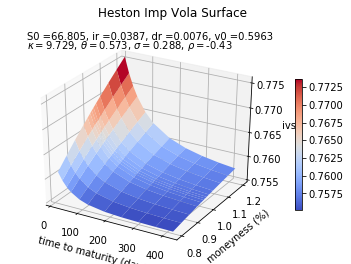

In [ ]:
# Plot example of volatility surface
he_group.show_ivs()
#he_group.show_ivs(sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=3,theta=0.1,sigma=0.4)

Now some data with random parameters are created in order to look whether the presented methodology is able to reproduce the parameters from the volatility surface.

In [ ]:
'''
Create historical data
'''

start_date = dt.datetime(2017,1,1)
end_date = dt.datetime(2017,1,5)

f_date = datetime_to_ql(start_date)
e_date = datetime_to_ql(end_date)
heston_processes = HestonGroup(first_date=f_date, end_date=e_date)
heston_processes.create_historical_process_data(save=True, seed=1)

('Date: ', Date(1,1,2017))
('Parameters: ', array([5.23609202, 0.3469791 , 0.28565028, 0.63076911]))
('Date: ', Date(2,1,2017))
('Parameters: ', array([ 1.83440414,  0.37491411,  0.06833857, -0.50125145]))
('Date: ', Date(3,1,2017))
('Parameters: ', array([7.51754125, 0.53945852, 0.70448549, 0.95608317]))
('Date: ', Date(4,1,2017))
('Parameters: ', array([3.93875242, 0.63637378, 0.58796988, 0.06379422]))
('Date: ', Date(5,1,2017))
('Parameters: ', array([5.93621589, 0.54839764, 0.65870864, 0.67797631]))
Saving historical data


In [ ]:
'''
Create training data ---- At least 20k points to obtain an acceptable calibration.
'''
heston_processes = HestonGroup()
heston_processes.training_data_param_to_iv(nb_samples=20000, seed=1, save=True, file_name='heston_trial')

Seed: 1
NN1-training data are produced
AssertionError('Price must be positive.',)
[ 2.43128573  0.47607535  0.77545725 -0.84749093]
Error: Zero implied volatility!, sample 8
 
AssertionError('Price must be positive.',)
[ 0.50381924  0.73895133  0.55930163 -0.15801651]
Error: Zero implied volatility!, sample 12
 
AssertionError('Price must be positive.',)
[ 3.01082609  0.16009428  0.65945794 -0.75347504]
Error: Zero implied volatility!, sample 22
 
AssertionError('Price must be positive.',)
[ 7.76924759  0.21837011  0.51435112 -0.82460227]
Error: Zero implied volatility!, sample 80
 
AssertionError('Price must be positive.',)
[ 4.03873828  0.0831161   0.74197902 -0.69794504]
Error: Zero implied volatility!, sample 94
 
AssertionError('Price must be positive.',)
[ 1.27155757  0.62556764  0.13803269 -0.56388502]
Error: Zero implied volatility!, sample 95
 
AssertionError('Price must be positive.',)
[ 2.36042522  0.12711378  0.57199738 -0.241345  ]
Error: Zero implied volatility!, sample 1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log


AssertionError('Initial guess must be positive.',)
[1.37812518 0.55580968 0.50592715 0.83404305]
Error: Zero implied volatility!, sample 6843
 
AssertionError('Price must be positive.',)
[ 1.64176187  0.23261356  0.43667087 -0.14036903]
Error: Zero implied volatility!, sample 6879
 
AssertionError('Price must be positive.',)
[1.65671757 0.07903181 0.19577831 0.00859609]
Error: Zero implied volatility!, sample 6903
 
AssertionError('Normalized price must be positive.',)
[1.15249982 0.42915548 0.63671454 0.9727642 ]
Error: Zero implied volatility!, sample 6928
 
AssertionError('Price must be positive.',)
[ 3.27631856  0.41726622  0.62654062 -0.8456589 ]
Error: Zero implied volatility!, sample 6937
 
AssertionError('Price must be positive.',)
[4.92775773 0.09922715 0.78704525 0.09486082]
Error: Zero implied volatility!, sample 6937
 
AssertionError('Price must be positive.',)
[ 1.84485223  0.10435686  0.29625375 -0.52309046]
Error: Zero implied volatility!, sample 6939
 
AssertionError('P

In [ ]:
'''
Function to transform input and output data to give the NN
'''

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func=None, inv_func=None, validate=True,
                 accept_sparse=False, pass_y=False):
        self.func = func
        self.inv_func = inv_func
        self.validate = validate
        self.accept_sparse = accept_sparse
        self.pass_y = pass_y
        
    def fit(self, X, y=None):
        if self.validate:
            check_array(X, self.accept_sparse)
        return self

    def transform(self, X, y=None):
        if self.validate:
            X = check_array(X, self.accept_sparse)
        if self.func is None:
            return X
        return self.func(X)
        
    def inverse_transform(self, X, y=None):
        if self.validate:
            X = check_array(X, self.accept_sparse)    
        if self.inv_func is None:
            return X
        return self.inv_func(X)

def transf_heston_parameters_in(y, transformation):
    len_y = y.shape[0]
    aux_vec = (y[:,:7]) #rho
    aux_vec = transformation(aux_vec)
    y = np.concatenate((aux_vec[:,:7],y[:,7].reshape(len_y,1)),axis=1)
    return  y

def transf_heston_prices(y, transformation):
    '''
    Also used for imp vola surfaces as data are all positive.
    '''
    y = transformation(y)
    return y

def transf_heston_parameters_out(y, transformation):
    len_y = y.shape[0]
    aux_vec = (y[:,:3]) #rho
    aux_vec = transformation(aux_vec)
    y = np.concatenate((aux_vec[:,:3],y[:,3].reshape(len_y,1)),axis=1)
    return  y

def preprocess_heston_param_NN1(x, func=he_analytic['transformation'], 
                            inv_func=he_analytic['inverse_transformation']):
    trm = MyTransformer(func=func, inv_func=inv_func)
#   scaler = StandardScaler()
    scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
    pipeline = Pipeline([('trm', trm), ('scaler', scaler)])
    x = transf_heston_parameters_in(x, pipeline.fit_transform)
    return x, pipeline

def preprocess_prices_or_vola(y):
    func = he_analytic['transformation']
    inv_func = he_analytic['inverse_transformation']
    trm = MyTransformer(func=func, inv_func=inv_func)
#   scaler = StandardScaler()
    scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
    pipeline = Pipeline([('trm', trm), ('scaler', scaler)])
    try:
        y = pipeline.fit_transform(y)
    except (TypeError,ValueError) as e:
        print(e)
        print('Max value: %s'%np.max(np.array(y)))
        print('Min value: %s'%np.min(np.array(y)))
    return y, pipeline

In [ ]:
'''
Retrieving data for NN1 and related functions.
'''
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

reorder_seed = 1027
tot_s = 1.
val_s = 0.1
test_s = 0.1

def split_database(total_size, valid_size, test_size, total_sample):
    train_size = total_size - valid_size - test_size
    train_sample = int(round(total_sample*train_size))
    valid_sample = int(round(total_sample*valid_size))
    test_sample = int(round(total_sample*test_size))
    print(train_sample, valid_sample, test_sample)
    if train_sample < 1 or train_sample > total_sample or \
        valid_sample < 0 or valid_sample > total_sample or \
        test_sample < 0 or test_sample > total_sample:
        total_sample -= train_sample
        if total_sample - valid_sample < 0:
            valid_sample = 0
            test_sample = 0
        else:
            total_sample -= valid_sample
            if total_sample - test_sample < 0:
                test_sample = 0
    return train_sample, valid_sample, test_sample


def cleaning_data_eliminate_version(db, indexes=None):
    '''
    Find the rows of the database that have negative elements and eliminate them.
    '''
    db = np.array(db)
    if indexes is None:
        indexes = (db<=0).sum(axis=1) #positions of rows with at least 1 non-positive element
    db = db[indexes==0] #eliminates these rows from the database
    return db, indexes #returns the array and the indexes

def retrieve_trainingset_NN(file_name, fin_model, 
                            force_positive_in=True, force_positive_out=True, 
                            whiten_in=False, whiten_out=False, seed=reorder_seed,
                            total_size=tot_s, valid_size=val_s, test_size=test_s):
    '''
    Function to load and preprocess Heston/Bates data from file in order to make
    them suitable for the Neural Networks.
    '''
    if force_positive_in and whiten_in:
        raise RuntimeError('Choose only one preprocessing type for input values!')
    if force_positive_out and whiten_out:
        raise RuntimeError('Choose only one preprocessing type for output values!')
    
    #To make it reproducible
    np.random.seed(seed)
    print('Reordering seed: %s '%seed)
    
    file_name = data_dir + '/' + file_name
    print('Current working dir: %s;  file name: %s'%(os.getcwd(), file_name))
    
    x = np.load(file_name+'_train_'+fin_model+'_find_iv_inputNN1.npy')
    y = np.load(file_name+'_train_'+fin_model+'_find_iv_outputNN1.npy')
    
    # Cleaning data
    y, indexes = cleaning_data_eliminate_version(db=y)
    print('Number of rejected samples: %s'%sum(indexes))
    x, _ = cleaning_data_eliminate_version(db=x, indexes=indexes)
    
    total_sample = y.shape[0]
    train_sample, valid_sample, test_sample = split_database(total_size, valid_size, 
                                                             test_size, total_sample)
    # INPUT
    if force_positive_in:
        print('--> Force positive input')
        x, pipeline_in = preprocess_heston_param_NN1(x)
    elif whiten_in:
        print('--> PCA & whitening used in input')
        x, pipeline_in = preprocess_prices_or_vola_pca(x)
    else:
        pipeline_in = None
        
    # OUTPUT
    if force_positive_out:
        print('--> Force positive output')
        y, pipeline_out = preprocess_prices_or_vola(y)
    elif whiten_out:
        print('--> PCA & whitening used in output')
        y, pipeline_out = preprocess_prices_or_vola_pca(y)
    else:
        pipeline_out = None
    
    index = np.arange(total_sample)
    np.random.shuffle(index)
    
    x_total, y_total = x[index], y[index]
    x_train, y_train = x_total, y_total
    if test_sample > 0:
        x_train, x_test, y_train, y_test =\
          train_test_split(x_train, y_train, test_size=test_sample, random_state=None)
    else:
        x_test = None
        y_test = None
    
    x_train, x_valid, y_train, y_valid =\
        train_test_split(x_train, y_train, test_size=valid_sample, random_state=None)
    
    return {'x_train': x_train, 'y_train': y_train, 
            'x_valid': x_valid, 'y_valid': y_valid, 
            'x_test': x_test, 'y_test': y_test, 
            'preprocess_in': pipeline_in, 'transform_out': pipeline_out}

In [ ]:
'''
Neural Network implementation
'''
from os.path import isfile
from os import getcwd
from copy import deepcopy, copy
import matplotlib.pyplot as plt
from six import string_types
import dill
from functools import partial
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Input
from keras.layers.merge import add
#from keras.regularizers import l2
from keras.layers.advanced_activations import ELU
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, \
                            Callback, TensorBoard
from keras import backend as K
from keras.constraints import maxnorm
#from keras import initializations
from keras.initializers import VarianceScaling, RandomUniform
#from keras.utils import Sequence
from keras.utils.vis_utils import plot_model


'''
Callbacks
'''
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=80, min_lr=9e-10, verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', patience=200)


'''
NN class
'''
def split_dataset(data):
    x_train = data['x_train']
    x_valid = data['x_valid']
    x_test = data['x_test']
    y_train = data['y_train']
    y_valid = data['y_valid']
    y_test = data['y_test']
    return x_train, x_valid, x_test, y_train, y_valid, y_test

def proper_name(name):
    name = name.replace(" ", "_")
    name = name.replace("(", "")
    name = name.replace(")", "")
    name = name.replace(",", "_")
    name = name.replace("-", "_")
    return name 

def reshape_fnn(x):
    if len(x[0].shape) == 1:
        p = np.concatenate(x)
        p.shape = (1, p.shape[0])
    else:
        p=x[None,:]
    return p

class NeuralNetwork(object):
    def __init__(self, model_name, model_callback, train_file_name,
                 lr=0.0005, loss='mean_squared_error', re_shape=reshape_fnn,
                 prefix='', postfix='', fin_model='he',
                 method=Nadam, checkPoint=True):
       
        self.model_name = model_name.lower()
        self.name = prefix + model_name
        self.postfix = postfix
        if self.postfix != '':
            self.postfix = '_'+self.postfix
        self.train_file_name = train_file_name
        self._fin_model = fin_model
        self._data = self.__get_data(fin_model=fin_model)
        self.x_train = None
        self.x_valid = None
        self.x_test = None
        self.y_train = None
        self.y_valid = None
        self.y_test = None
        self.model = None
        self.history = None
        self.method = method
        self._transform = self._data['transform_out']
        self._model_callback = model_callback
        self.lr = lr
        self.loss = loss
        self._reshape = re_shape
        self._preprocessing = self._data['preprocess_in']
        self.checkPoint = checkPoint
        print('Class NeuralNetwork, __init__ finished.')
        
        
    def __get_data(self, fin_model):
        # File name is h5_model_node + _ + risk factor + '_' + self.name
        self.train_file_name = proper_name(self.train_file_name)
        self.train_file_name = self.train_file_name.replace('/', '_')
        print(self.train_file_name) 
        return retrieve_trainingset_NN(self.train_file_name, fin_model=fin_model)

    def file_names(self):
        # File name is self.name + _nn
        file_name = proper_name(self.name) + '_nn' + self.postfix
        file_name = file_name.lower().replace('/', '_')
        return (data_dir + '/' + file_name, file_name)

    def __tofile(self):
        file_name, _ = self.file_names()
        if self.model is not None:
            json_file = file_name + '.json' #saving architecture
            json = self.model.to_json()
            open(json_file, 'w').write(json)
            if not self.checkPoint:
                print('Saving weights...')
                h5_file = file_name + '.h5' #saving weights
                self.model.save_weights(h5_file, overwrite=True)

    def __fromfile(self):
        file_name, _ = self.file_names()
        json_file = file_name + '.json'
        if isfile(json_file):
            self.model = model_from_json(open(json_file).read())
            h5_file = file_name + '.h5'
            self.model.load_weights(h5_file)
            print('Reading NN from file and setting learning rate to ',self.lr)
            method = self.method(lr=self.lr, clipnorm=1.)
            self.model.compile(optimizer=method, loss=self.loss)
        else:
            self.model = None

    def __getstate__(self):
        print("I'm being pickled!")
        self.__tofile()
        model = self.model
        del self.__dict__['model']
        d = deepcopy(self.__dict__)
        self.model = model
        del d['_data']
        del d['x_train']
        del d['x_valid']
        del d['x_test']
        del d['y_train']
        del d['y_valid']
        del d['y_test']
        return d

#   def __setstate__(self, d):
#       print "I'm being unpickled with these values: "#, d #Values taken from .p file
#       self.__dict__ = d
#       self._data = None
#       history = self.history
#       self.train(nb_epochs=0)
#       self.history = history
#       self.__fromfile()

    def train(self, nb_epochs):
        print('Train function of class NeuralNetwork called with %s epochs.'%nb_epochs)
        if nb_epochs > 0: 
            self.y_train = self._data['y_train'] 
            self.y_valid = self._data['y_valid']
            self.y_test = self._data['y_test'] 
            method = self.method(lr=self.lr, clipnorm=1.) #gradient clipnorm
            cp_file_name, simple_file_name = self.file_names()
            self.x_train, self.x_valid, self.x_test, self.model, self.history = \
                self._model_callback(self._data, method, self.loss, 
                                     nb_epochs=nb_epochs, CP=self.checkPoint,
                                     CP_name=cp_file_name, model_name=simple_file_name)
            if len(self.y_test)>0:
                print(' '); print ('   -- NN on Test set --')
#                print self.model.evaluate(self.x_test, self.y_test, batch_size=128)
                print(self.model.evaluate(self.x_test, self.y_test, 
                                          batch_size=self.history['params']['batch_size']))
                print(' ')


    def fit(self, nb_epochs):
        if self.model is None:
            raise RuntimeError('Model not yet instantiated')
        print('Now fitting the neural network model...')
        batch_size = self.history['params']['batch_size']
        history2 = self.model.fit(self.x_train, self.y_train, batch_size=batch_size, 
                          nb_epoch=nb_epochs, verbose=1, 
                          validation_data=(self.x_valid, self.y_valid))
        self.history = {'history': history2.history,
                        'params': history2.params}

    def predict(self, data):
        if self.model is None:
            raise RuntimeError('Model not yet instantiated')
        if self._reshape is not None:
            data = self._reshape(data)
        if self._preprocessing is not None:
            # Preprocessing applied in predict phase
            data = transf_heston_parameters_in(y=data, transformation=self._preprocessing.transform)
        y = self.model.predict(data)
        if self._transform is not None:
            # Postprocessing applied in predict phase
            y = transf_heston_prices(y=y, transformation=self._transform.inverse_transform)
        return y

/usr/local64.hg/app/python/3.6.8-3.fc28.rpm-20190521/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
'''
Functions to generate different neural networks
'''
def design_model(method, activation, exponent, init, layers, loss='mse', 
                 dropout_first=None, dropout_middle=None, dropout_last=None, 
                 neurons_first=None, neurons_last=None, weight_constraint=None,
                 dropout=None, tuning=False, **kwargs):
    
    c = weight_constraint
    
    if type(exponent)==str:
        exponent = eval(exponent)
    nb_unit = int(2**exponent)
    
    if dropout_first is None:
        dropout_first = dropout
    if dropout_middle is None:
        dropout_middle = dropout_first
    if dropout_last is None:
        dropout_last = dropout_middle
        
    act_idx = 1
    ## Input of model
    inp = Input(shape=(neurons_first,))
    ## Output of model
    # First layer
    ly = Dense(nb_unit, kernel_initializer=init,
               kernel_constraint=maxnorm(c, axis=0),
               use_bias=False)(inp)
    ly = BatchNormalization()(ly)
    act = copy(activation)
    act.name = act.name+'_'+str(act_idx)
    act_idx += 1
    ly = act(ly)
    ly = Dropout(dropout_first)(ly)
    
    # Middle layers
    for i in range(layers-1):
        middle = Dense(nb_unit, kernel_initializer=init, 
                       kernel_constraint=maxnorm(c, axis=0),
                       use_bias=False)(ly)
        middle = BatchNormalization()(middle)
        act = copy(activation)
        act.name = act.name+'_'+str(act_idx)
        act_idx += 1
        middle = act(middle)
        middle = Dropout(dropout_middle)(middle)
        ly = add([ly, middle])
        act = copy(activation)
        act.name = act.name+'_'+str(act_idx)
        act_idx += 1
        ly = act(ly)
        #BN after addition messes up infotmation: (see link below)
        # https://github.com/abhshkdz/papers/blob/master/reviews/identity-mappings-in-deep-residual-networks.md
    # Last layer
    ly = Dense(neurons_last, kernel_initializer=init, 
               kernel_constraint=maxnorm(c, axis=0),
               use_bias=False)(ly)
    ly = BatchNormalization()(ly)
    act_idx += 1
    ly = Activation('linear')(ly)
    ly = Dropout(dropout_last)(ly)
    
    ## Put together input and output
    nn = Model(inputs=inp, outputs=ly)
    
    # Compile
    nn.compile(optimizer=method, loss=loss)
    
    return (nn, nb_unit, act_idx)

In [ ]:
'''
Feedforward NN
'''
def fnn_model(data, method, loss='mse', exponent=8, nb_epochs=0, 
              batch_size=128, activation='tanh', layers=4, 
              init='he_uniform', dropout=0.5, dropout_first=None, 
              dropout_middle=None, dropout_last=None,
              neurons_first=None, neurons_last=None, CP=True,
              CP_name=None, **kwargs):
    
#    print activation
    assert(isinstance(activation, string_types))
    
    if activation == 'elu':
        alpha = kwargs.get('alpha',1.0)
        activation = ELU(alpha)
    else:
        activation = Activation(activation)
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = split_dataset(data)
    
    if not(neurons_first):
        neurons_first = x_train.shape[1]
    if not(neurons_last):
        neurons_last = y_train.shape[1]
        
    c = kwargs.get('c', None)
    
    nn, nb_unit, _ = design_model(method, activation, exponent, init, layers, loss,
                                     dropout_first, dropout_middle, dropout_last,
                                     neurons_first, neurons_last, 
                                     weight_constraint=c, **kwargs)
    if nb_epochs > 0:
        callbacks_list = [earlyStopping]
        callbacks_list.append(reduceLR)
        
        if CP:
            filepath = CP_name + '.h5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                         save_best_only=True, mode='min')
            callbacks_list.append(checkpoint)
        print('Callbacks: ' + ', '.join([str(cb) for cb in callbacks_list]))
        
        history2 = nn.fit(x_train, y_train, batch_size=batch_size, 
                          epochs=nb_epochs, verbose=2, callbacks=callbacks_list,
                          validation_data=(x_valid, y_valid))

        min_index, min_value = min(enumerate(history2.history['val_loss']), 
                                   key=lambda p: p[1])
        
        print('Min losses - epoch %s and val_loss: %s, training loss: %s'%(
                min_index+1, min_value, history2.history['loss'][min_index]))
        
        history = {'history': history2.history,
                   'params': history2.params}
    else:
        history = {'history': [],
                   'params': []}
    return (x_train, x_valid, x_test, nn, history)

In [ ]:
'''
Function to be called to generate the NN-model
'''
def generate_nn(exponent=8, batch_size=512, lr=5e-5, layers=6, loss='mse',
                activation='tanh', prefix='', postfix='', dropout=0.5, 
                dropout_first=None, dropout_middle=None, dropout_last=None, 
                residual_cells=0, **kwargs):
    
    init = kwargs.get('init', 'glorot_uniform')
    c = kwargs.get('c', None)
    fin_model = kwargs.get('fin_model','')
    train_file_name = kwargs.get('train_file_name', 
                                 he_analytic['name'].lower()) 
    check_point = kwargs.get('check_point',True)
    
    callb = partial(fnn_model, exponent=exponent, batch_size=batch_size, 
                    activation=activation, layers=layers, dropout=dropout, 
                    dropout_first=dropout_first, dropout_middle=dropout_middle,
                    dropout_last=dropout_last, lr=lr, c=c, init=init)
    
    model = NeuralNetwork(he_analytic['name'].lower(), 
                          model_callback=callb, train_file_name=train_file_name, 
                          fin_model=fin_model, lr=lr, loss=loss, 
                          re_shape=reshape_fnn, prefix=prefix, 
                          postfix=postfix, checkPoint=check_point)
    return model

In [ ]:
#'''
#Functions to save a model to file or load it back
#'''
def write_model(model):
    model_file_name, _ = model.file_names()
    file_name = model_file_name + '.p'
    print('Saving model to file: %s' % file_name)
    dill.dump(model, open(file_name, 'wb'))

#def read_model(file_name):
#    file_name = file_name + '.p'
#    print('Reading model from file: %s' % file_name)
#    model = dill.load(open(file_name, 'rb'))
#    return model

## Training of the neural network (called model here)

In the sequel the model is trained over 250 epochs.

In [ ]:
model = generate_nn(exponent=8, activation='elu',
                    train_file_name='heston_heston_trial',
                    layers=6, lr=5e-4,
                    prefix='', postfix='',
                    dropout_first=0, dropout_middle=0,
                    dropout_last=0, batch_size=1024, 
                    fin_model='he',c=5, check_point = True)

heston_heston_trial
Reordering seed: 1027 
Current working dir: /scratch/users/jteichma/Desktop/lecture_ML;  file name: /scratch/users/jteichma/Desktop/lecture_ML/heston_heston_trial
Number of rejected samples: 0
16000 2000 2000
--> Force positive input
--> Force positive output
Class NeuralNetwork, __init__ finished.


In [ ]:
model.train(nb_epochs=250)
write_model(model)

Train function of class NeuralNetwork called with 250 epochs.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Callbacks: <keras.callbacks.EarlyStopping object at 0x7fa165c1eb38>, <keras.callbacks.ReduceLROnPlateau object at 0x7fa165c1ea90>, <keras.callbacks.ModelCheckpoint object at 0x7fa102fdfda0>
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 16000 samples, validate on 2000 samples
Epoch 1/250
Epoch 00000: val_loss improved from inf to 0.53172, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
1s - loss: 1.0369 - val_loss: 0.5317
Epoch 2/250
Epoch 00001: val_loss did not improve
0s - loss: 0.7602 - val_loss: 0.6112
Epoch 3/250
Epoch 00002: val_loss improved from 0.53172 to 0.36295, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.7084 - val_loss: 0.3629
Epoch 4/250
Epoch 00003: val_loss improved from 0.36295 to 0.15382, saving model to /scratch/users/jteichma/Desktop/

Epoch 00074: val_loss improved from 0.06244 to 0.06219, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0650 - val_loss: 0.0622
Epoch 76/250
Epoch 00075: val_loss improved from 0.06219 to 0.05936, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0625 - val_loss: 0.0594
Epoch 77/250
Epoch 00076: val_loss improved from 0.05936 to 0.05109, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0599 - val_loss: 0.0511
Epoch 78/250
Epoch 00077: val_loss did not improve
0s - loss: 0.0576 - val_loss: 0.0556
Epoch 79/250
Epoch 00078: val_loss did not improve
0s - loss: 0.0550 - val_loss: 0.0565
Epoch 80/250
Epoch 00079: val_loss improved from 0.05109 to 0.04875, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
1s - loss: 0.0529 - val_loss: 0.0487
Epoch 81/250
Epoch 00080: val_loss did not improve
1s - loss: 0.0507 - val_loss: 0.0497
Epoch 82/250
Epoch 00081: val_loss im

Epoch 00130: val_loss improved from 0.00468 to 0.00385, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0042 - val_loss: 0.0039
Epoch 132/250
Epoch 00131: val_loss did not improve
0s - loss: 0.0042 - val_loss: 0.0050
Epoch 133/250
Epoch 00132: val_loss improved from 0.00385 to 0.00365, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0039 - val_loss: 0.0036
Epoch 134/250
Epoch 00133: val_loss did not improve
0s - loss: 0.0036 - val_loss: 0.0040
Epoch 135/250
Epoch 00134: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0039
Epoch 136/250
Epoch 00135: val_loss improved from 0.00365 to 0.00327, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0032 - val_loss: 0.0033
Epoch 137/250
Epoch 00136: val_loss improved from 0.00327 to 0.00315, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 0.0030 - val_loss: 0.0031
Epoch 138/250
Epoch 00137: val_

Epoch 00189: val_loss did not improve
0s - loss: 4.1467e-04 - val_loss: 3.2193e-04
Epoch 191/250
Epoch 00190: val_loss did not improve
0s - loss: 4.2709e-04 - val_loss: 4.3258e-04
Epoch 192/250
Epoch 00191: val_loss did not improve
0s - loss: 2.9069e-04 - val_loss: 5.0136e-04
Epoch 193/250
Epoch 00192: val_loss did not improve
0s - loss: 3.1267e-04 - val_loss: 4.4026e-04
Epoch 194/250
Epoch 00193: val_loss improved from 0.00032 to 0.00026, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - loss: 3.5057e-04 - val_loss: 2.6317e-04
Epoch 195/250
Epoch 00194: val_loss did not improve
0s - loss: 3.1485e-04 - val_loss: 4.2193e-04
Epoch 196/250
Epoch 00195: val_loss did not improve
0s - loss: 2.8561e-04 - val_loss: 3.0862e-04
Epoch 197/250
Epoch 00196: val_loss did not improve
0s - loss: 3.7997e-04 - val_loss: 3.0627e-04
Epoch 198/250
Epoch 00197: val_loss improved from 0.00026 to 0.00024, saving model to /scratch/users/jteichma/Desktop/lecture_ML/heston_nn.h5
0s - l

This the essential step: the trained neural network is used for the formulation of an inverse problem.

In [ ]:
'''
Calibration of the model through the map NN1.
'''
from scipy.optimize import minimize, differential_evolution



def cost_function_calibr_with_NN1(obj, pred_model1, observables, l2=False, **kwargs):
    # obj will be our ivs
    def cost_function(params):
        params = params.flatten().tolist()
        input_params = observables[:]
        input_params.extend(params)
        predicted_obj = (pred_model1.predict(np.array(input_params))).ravel()
#        diff = predicted_obj/obj - 1.0 #relative error
        diff = predicted_obj - obj #absolute error
        if l2:
            return np.sum(diff**2)
        else:
            return np.sum(np.abs(diff))
    return cost_function

def heston_handle_v0_as_param(observables, params):
    v0 = observables[3]
    parameters = params.tolist()
    parameters.insert(0,v0)
    return parameters

def calibration_through_nn1(pred_model1, fin_model, method):
    '''
    Alternative way of parametrizing the process (e.g. Heston) using NN1 as a 
    pricing map.
    '''
    #Dictionaries
    hist_prices_df = load_dictionary(name_dict=fin_model+'_hist_df')
    dates = sorted(hist_prices_df.keys())
    hist_observable = load_dictionary(name_dict=fin_model+'_observable')
    hist_prices = {}
    for k in sorted(hist_prices_df.keys()):
        hist_prices[k] = hist_prices_df[k]['price']
    
    hist_variables = load_dictionary(name_dict=fin_model+'_hist_iv')
    hist_params = load_dictionary(name_dict=fin_model+'_hist_parameters')
    
    cal_params = {}
    max_it = 100
    
    for date in dates:
        print(datetime_to_ql(date))
        target_obj = np.array((hist_variables[date]))
        observables = hist_observable[date]
        observables = observables.flatten().tolist()
        cost_function = cost_function_calibr_with_NN1(target_obj, pred_model1,  
                                        observables, l2=True)
        
        if method == 'slsqp':
            initial_guess = he_mean_as_initial_point
            sol = minimize(cost_function, initial_guess,
                           bounds=he_calibration_bounds, 
                           method='SLSQP', options={'maxiter':max_it})
        elif method == 'diff_ev':
            sol = differential_evolution(func=cost_function,
                                         bounds=he_calibration_bounds, 
                                         maxiter=max_it)
        cal_params[date] = sol.x
        print('Calibrated parameters: %s'%cal_params[date])
        print('Historical parameters: %s'%hist_params[date])
        print('Final value: ', sol.fun)
        print('Iterations: ',sol.nit); print(' ')
        parameters = heston_handle_v0_as_param(observables=observables, params=cal_params[date])
        
    # Saving dictionaries
    name_dict = 'nn1_calibrated_params_he'
    save_dictionary(dictionary=cal_params, name_dict=name_dict)


In [ ]:
calibration_through_nn1(pred_model1=model, fin_model='he', method='diff_ev')

January 1st, 2017
Calibrated parameters: [6.3767572  0.24523514 0.52178055 0.61209502]
Historical parameters: [5.86891705 0.23674519 0.48581013 0.76684758]
Final value:  0.003695758446023043
Iterations:  37
 
January 2nd, 2017
Calibrated parameters: [6.87779793 0.6844554  0.57640076 0.36985988]
Historical parameters: [7.02215964 0.69591619 0.77282953 0.28776039]
Final value:  0.000866345629150049
Iterations:  42
 
January 3rd, 2017
Calibrated parameters: [4.44865667 0.65250898 0.26846926 0.61766543]
Historical parameters: [5.29151815 0.65235408 0.65180714 0.31680366]
Final value:  0.0021271409369537316
Iterations:  34
 
January 4th, 2017
Calibrated parameters: [ 4.49099914  0.2053842   0.35858193 -0.40453734]
Historical parameters: [ 3.51394069  0.18448265  0.29862568 -0.33750285]
Final value:  0.001746952591317545
Iterations:  42
 
January 5th, 2017
Calibrated parameters: [ 2.01503571  0.19556692  0.39358472 -0.1744007 ]
Historical parameters: [ 1.51580394  0.17884862  0.67095647 -0.0

In [ ]:
dispatch_names = {}
dispatch_names['he'] = 'Heston'

dispatch_string2 = {}
dispatch_string2['he'] = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']

def params_to_string(obj, params_h, params_c, fin_model):
    obs_str = [r'$S_0 = $', 'ir = ', 'dr = ', r'$v_0 = $']
    obs = [obj[0],obj[1],obj[2],obj[3]]
    obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]

    params_str_h = ["{}{:.5}".format(o, str(v)) 
                            for o,v in zip(dispatch_string2[fin_model], params_h)]
    params_str_c = ["{}{:.5}".format(o, str(v)) 
                            for o,v in zip(dispatch_string2[fin_model], params_c)]
    return obs_str, params_str_h, params_str_c


def nn1_calibration_plot(pred_model1, date_index=0):
    
    hist_observable = load_dictionary(name_dict='he_observable')
    dates = sorted(hist_observable.keys())
    date = dates[date_index]
    
    hist_params = load_dictionary(name_dict='he_hist_parameters')
    hist_ivs = load_dictionary(name_dict='he_hist_iv')
    cal_params = load_dictionary(name_dict='nn1_calibrated_params_he')

    obj = hist_observable[date]
    obj = obj.tolist()
    obs_str, params_h_str, params_c_str = params_to_string(obj, 
                hist_params[date].tolist(), cal_params[date].tolist(), 'he')
    nn1_input = np.concatenate((np.array(obj),cal_params[date]))
    W = pred_model1.predict(nn1_input)
    plot_surface(Z=np.array(hist_ivs[date]), z_label='ivs', 
                 main_title=dispatch_names['he']+' - Calibrated IVS with NN1', 
                 string1=', '.join(o for o in obs_str), 
                 string2='Hist params: '+', '.join(o for o in params_h_str), 
                 W=W, string3='Cal params: '+', '.join(o for o in params_c_str))

def nn1_illustration_plot(pred_model1, date_index=0):
    
    hist_observable = load_dictionary(name_dict='he_observable')
    dates = sorted(hist_observable.keys())
    date = dates[date_index]
    
    hist_params = load_dictionary(name_dict='he_hist_parameters')
    hist_ivs = load_dictionary(name_dict='he_hist_iv')
    #cal_params = load_dictionary(name_dict='nn1_calibrated_params_he')

    obj = hist_observable[date]
    obj = obj.tolist()
    obs_str, params_h_str, params_c_str = params_to_string(obj, 
                hist_params[date].tolist(), hist_params[date].tolist(), 'he')
    nn1_input = np.concatenate((np.array(obj),hist_params[date]))
    W = pred_model1.predict(nn1_input)
    plot_surface(Z=np.array(hist_ivs[date]), z_label='ivs', 
                 main_title=dispatch_names['he']+' - Calibrated IVS with NN1', 
                 string1=', '.join(o for o in obs_str), 
                 string2='Hist params: '+', '.join(o for o in params_h_str), 
                 W=W, string3='Hist params: '+', '.join(o for o in params_c_str))

In the sequel we see two plots: the first one compares the real volatility surface (given some Heston) parameters with the one from the trained neural network. The second looks what the inverse problem given by means of the neural network would choose as parameters to reproduce the given volatility surface on the left hand side.

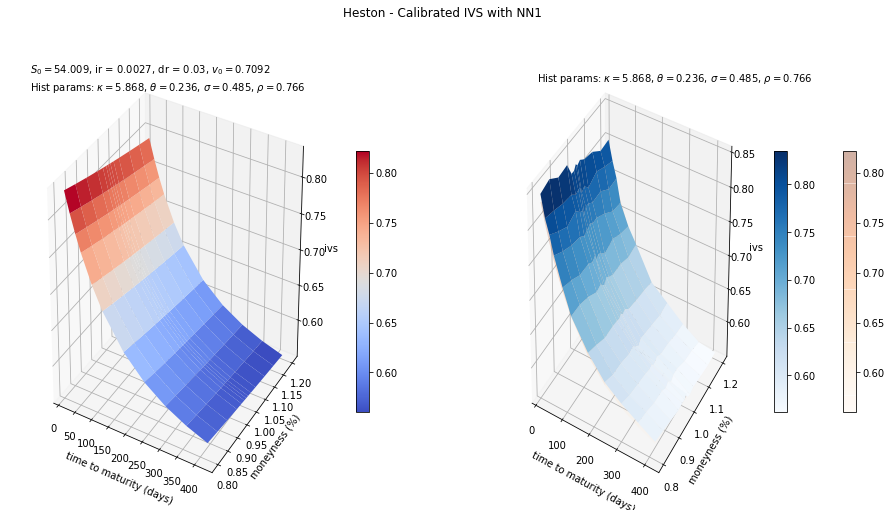

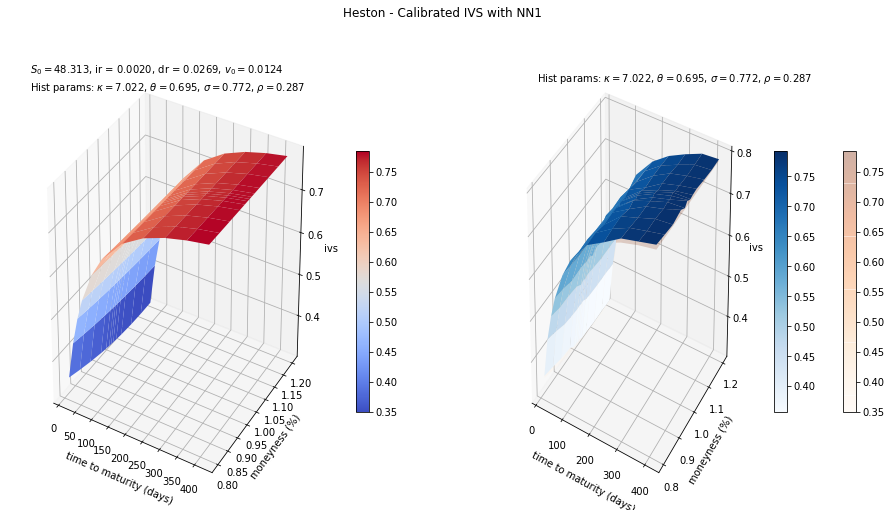

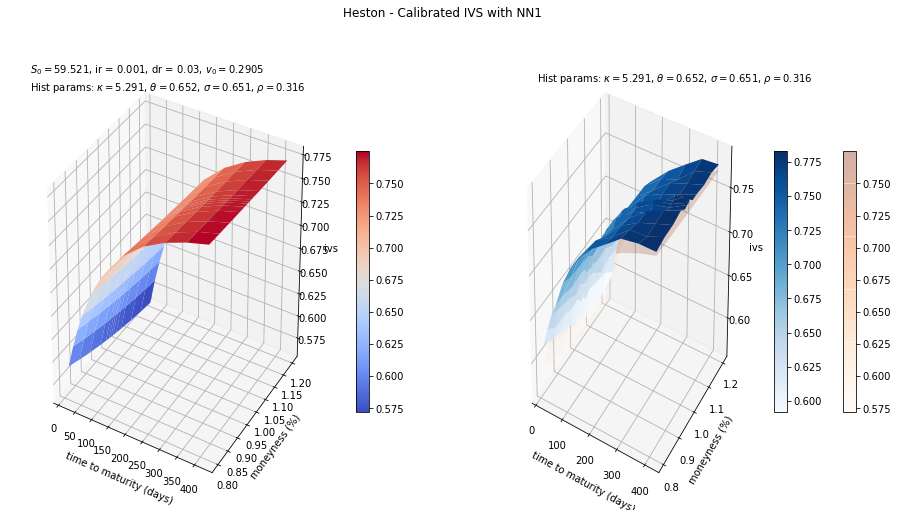

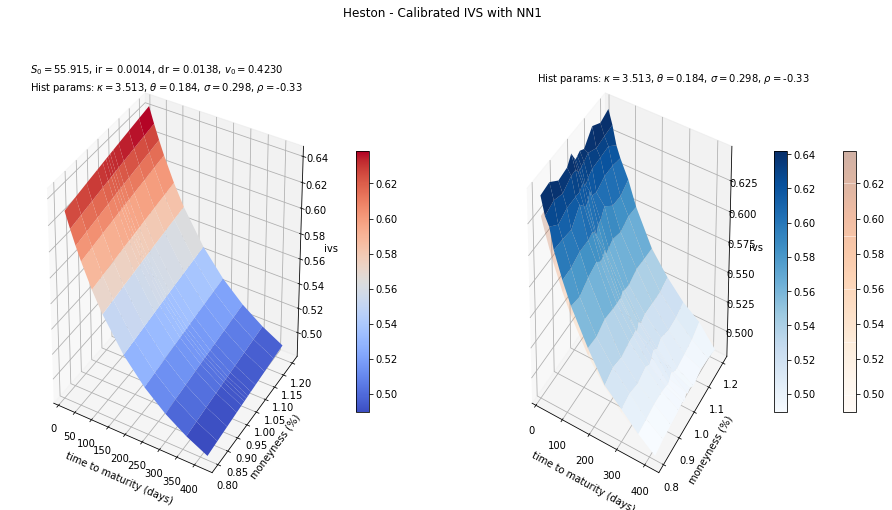

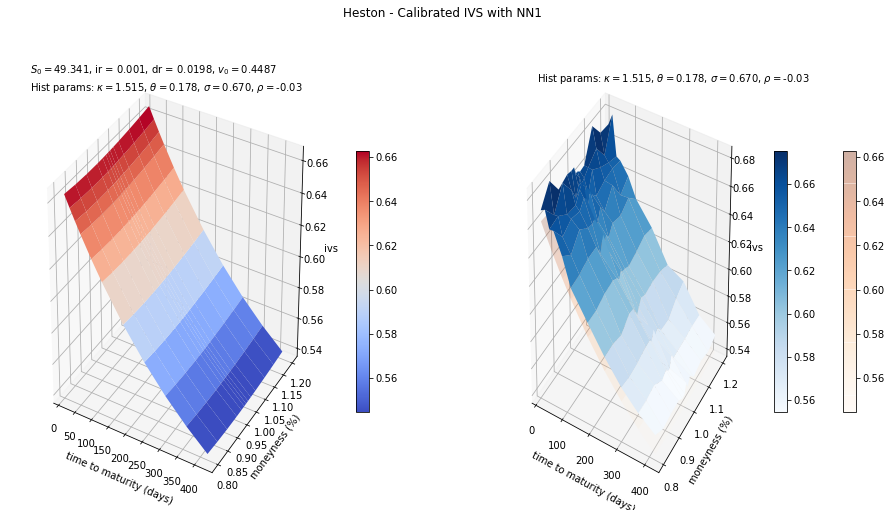

In [ ]:
hist_observable = load_dictionary(name_dict='he_observable')
N = len(hist_observable.keys())
for i in range(N):
    nn1_illustration_plot(pred_model1=model, date_index=i)

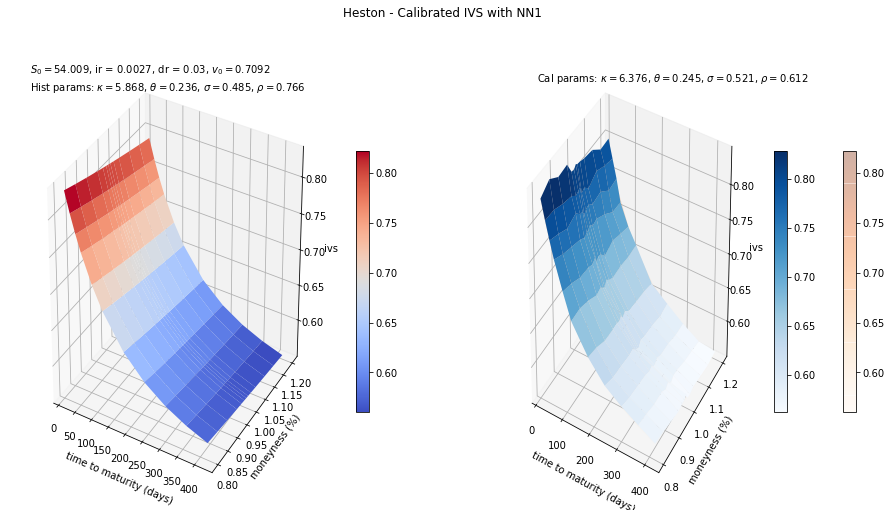

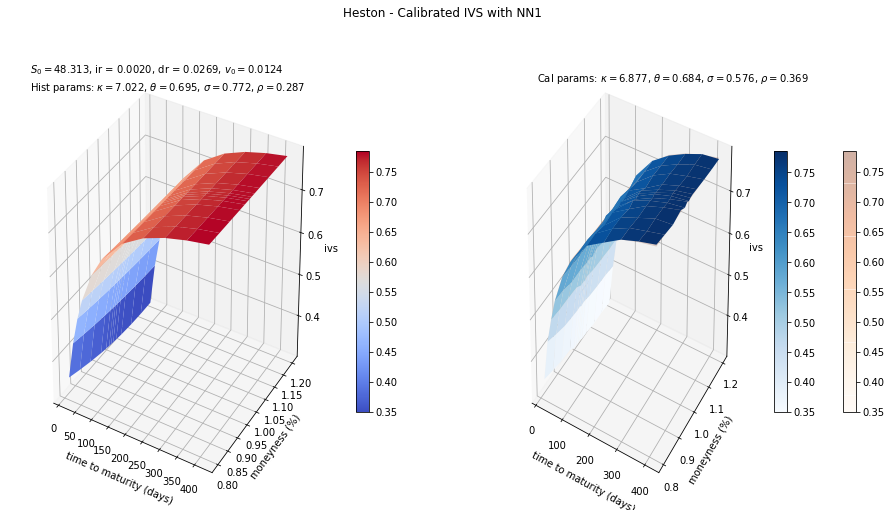

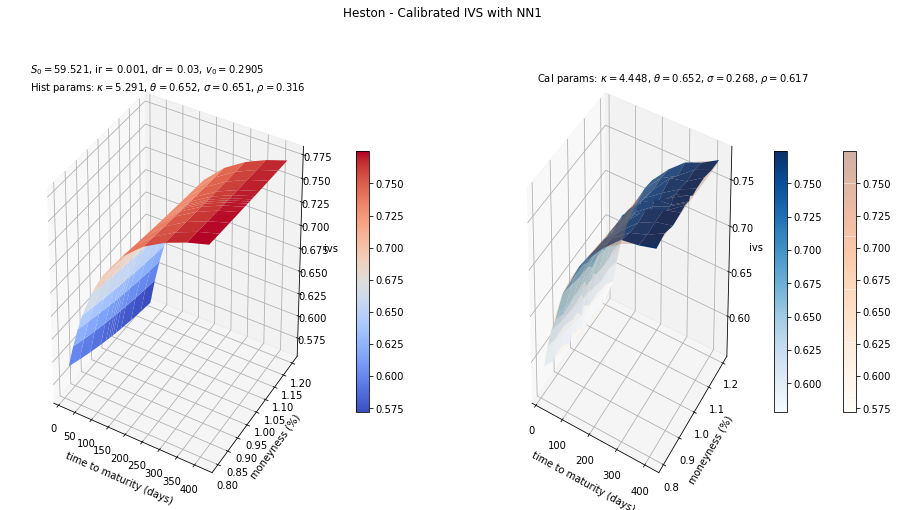

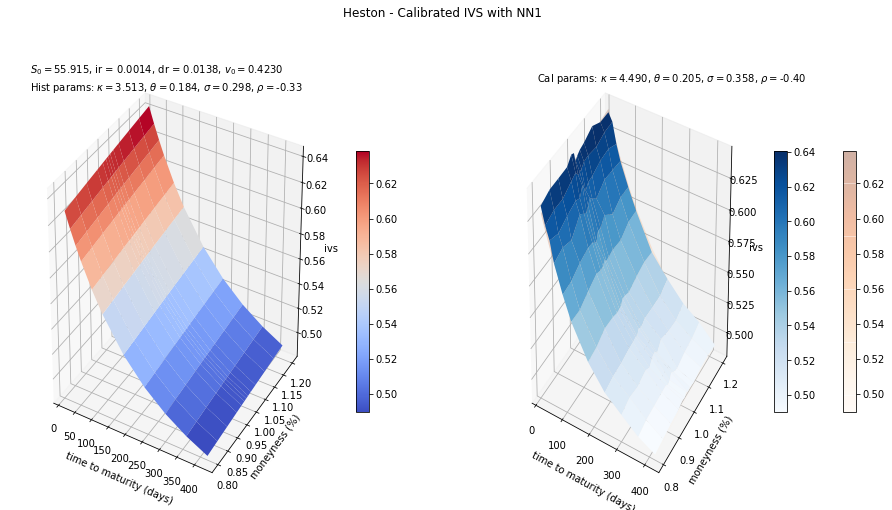

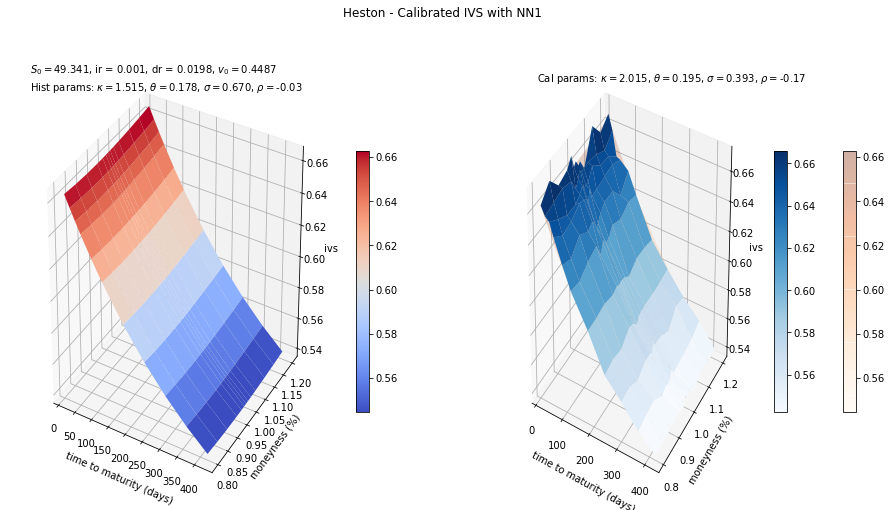

In [ ]:
hist_observable = load_dictionary(name_dict='he_observable')
N = len(hist_observable.keys())
for i in range(N):
    nn1_calibration_plot(pred_model1=model, date_index=i)

The following example shows how this calibration exercise would look in classical Quantlib style, I follow here notes from the great [blog entry](http://gouthamanbalaraman.com/blog/heston-calibration-scipy-optimize-quantlib-python.html) of Goutham Balaraman.

In [ ]:
import QuantLib as ql
from math import pow, sqrt
import numpy as np
from scipy.optimize import root

In [ ]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
calculation_date = ql.Date(6, 11, 2015)

spot = 659.37
ql.Settings.instance().evaluationDate = calculation_date

risk_free_rate = 0.01
dividend_rate = 0.0
yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [ ]:
expiration_dates = [ql.Date(6,12,2015), ql.Date(6,1,2016), ql.Date(6,2,2016),
                    ql.Date(6,3,2016), ql.Date(6,4,2016), ql.Date(6,5,2016), 
                    ql.Date(6,6,2016), ql.Date(6,7,2016), ql.Date(6,8,2016),
                    ql.Date(6,9,2016), ql.Date(6,10,2016), ql.Date(6,11,2016), 
                    ql.Date(6,12,2016), ql.Date(6,1,2017), ql.Date(6,2,2017),
                    ql.Date(6,3,2017), ql.Date(6,4,2017), ql.Date(6,5,2017), 
                    ql.Date(6,6,2017), ql.Date(6,7,2017), ql.Date(6,8,2017),
                    ql.Date(6,9,2017), ql.Date(6,10,2017), ql.Date(6,11,2017)]
strikes = [527.50, 560.46, 593.43, 626.40, 659.37, 692.34, 725.31, 758.28]
data = [
[0.37819, 0.34177, 0.30394, 0.27832, 0.26453, 0.25916, 0.25941, 0.26127],
[0.3445, 0.31769, 0.2933, 0.27614, 0.26575, 0.25729, 0.25228, 0.25202],
[0.37419, 0.35372, 0.33729, 0.32492, 0.31601, 0.30883, 0.30036, 0.29568],
[0.37498, 0.35847, 0.34475, 0.33399, 0.32715, 0.31943, 0.31098, 0.30506],
[0.35941, 0.34516, 0.33296, 0.32275, 0.31867, 0.30969, 0.30239, 0.29631],
[0.35521, 0.34242, 0.33154, 0.3219, 0.31948, 0.31096, 0.30424, 0.2984],
[0.35442, 0.34267, 0.33288, 0.32374, 0.32245, 0.31474, 0.30838, 0.30283],
[0.35384, 0.34286, 0.33386, 0.32507, 0.3246, 0.31745, 0.31135, 0.306],
[0.35338, 0.343, 0.33464, 0.32614, 0.3263, 0.31961, 0.31371, 0.30852],
[0.35301, 0.34312, 0.33526, 0.32698, 0.32766, 0.32132, 0.31558, 0.31052],
[0.35272, 0.34322, 0.33574, 0.32765, 0.32873, 0.32267, 0.31705, 0.31209],
[0.35246, 0.3433, 0.33617, 0.32822, 0.32965, 0.32383, 0.31831, 0.31344],
[0.35226, 0.34336, 0.33651, 0.32869, 0.3304, 0.32477, 0.31934, 0.31453],
[0.35207, 0.34342, 0.33681, 0.32911, 0.33106, 0.32561, 0.32025, 0.3155],
[0.35171, 0.34327, 0.33679, 0.32931, 0.3319, 0.32665, 0.32139, 0.31675],
[0.35128, 0.343, 0.33658, 0.32937, 0.33276, 0.32769, 0.32255, 0.31802],
[0.35086, 0.34274, 0.33637, 0.32943, 0.3336, 0.32872, 0.32368, 0.31927],
[0.35049, 0.34252, 0.33618, 0.32948, 0.33432, 0.32959, 0.32465, 0.32034],
[0.35016, 0.34231, 0.33602, 0.32953, 0.33498, 0.3304, 0.32554, 0.32132],
[0.34986, 0.34213, 0.33587, 0.32957, 0.33556, 0.3311, 0.32631, 0.32217],
[0.34959, 0.34196, 0.33573, 0.32961, 0.3361, 0.33176, 0.32704, 0.32296],
[0.34934, 0.34181, 0.33561, 0.32964, 0.33658, 0.33235, 0.32769, 0.32368],
[0.34912, 0.34167, 0.3355, 0.32967, 0.33701, 0.33288, 0.32827, 0.32432],
[0.34891, 0.34154, 0.33539, 0.3297, 0.33742, 0.33337, 0.32881, 0.32492]]

In [ ]:
def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator(model, helpers,norm=False):
    def cost_function(params):
        params_ = ql.Array(list(params))
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers]
        if norm:
            return np.sqrt(np.sum(np.abs(error)))
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    avg = 0.0
    if detailed:
        print("%15s %25s %15s %15s %20s" % (
            "Strikes", "Expiry", "Market Value", 
             "Model Value", "Relative Error (%)"))
        print("="*100)
    for i, opt in enumerate(helpers):
        err = (opt.modelValue()/opt.marketValue() - 1.0)
        date,strike = grid_data[i]
        if detailed:
            print("%15.2f %25s %14.5f %15.5f %20.7f " % (
                strike, str(date), opt.marketValue(), 
                opt.modelValue(), 
                100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
        avg += abs(err)
    avg = avg*100.0/len(helpers)
    if detailed: print("-"*100)
    summary = "Average Abs Error (%%) : %5.9f" % (avg)
    print(summary)
    return avg
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine
summary= []


In [ ]:
#theta, kappa, sigma, rho, v0 = (0.02, 0.2, 0.5, 0.1, 0.01)
#theta, kappa, sigma, rho, v0 = (0.07, 0.5, 0.1, 0.1, 0.1)

In [ ]:
model1, engine1 = setup_model(
    yield_ts, dividend_ts, spot, 
    init_condition=(0.02,0.2,0.5,0.1,0.01))
heston_helpers1, grid_data1 = setup_helpers(
    engine1, expiration_dates, strikes, data, 
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model1.params())

In [ ]:
%%time
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model1.calibrate(heston_helpers1, lm, 
                 ql.EndCriteria(500, 300, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model1.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" %
      (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers1, grid_data1)
summary.append(["QL LM1", error] + list(model1.params()))

theta = 0.125748, kappa = 7.915000, sigma = 1.887854, rho = -0.364942, v0 = 0.055397
Average Abs Error (%) : 3.015268052
CPU times: user 1.31 s, sys: 1.92 ms, total: 1.31 s
Wall time: 1.33 s


In [ ]:
model1, engine1 = setup_model(
    yield_ts, dividend_ts, spot, 
    init_condition=(0.07,0.5,0.1,0.1,0.1))
heston_helpers1, grid_data1 = setup_helpers(
    engine1, expiration_dates, strikes, data, 
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model1.params())

In [ ]:
%%time
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model1.calibrate(heston_helpers1, lm, 
                 ql.EndCriteria(500, 300, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model1.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers1, grid_data1)
summary.append(["QL LM2", error] + list(model1.params()))

theta = 0.084523, kappa = 0.000000, sigma = 0.132289, rho = -0.514276, v0 = 0.099928
Average Abs Error (%) : 11.007438738
CPU times: user 1.32 s, sys: 1.85 ms, total: 1.32 s
Wall time: 1.32 s


In [ ]:
model2, engine2 = setup_model(
    yield_ts, dividend_ts, spot, 
    init_condition=(0.02,0.2,0.5,0.1,0.01))
heston_helpers2, grid_data2 = setup_helpers(
    engine2, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model2.params())

In [ ]:
%%time
cost_function = cost_function_generator(model2, heston_helpers2)
sol = root(cost_function, initial_condition, method='lm')
theta, kappa, sigma, rho, v0 = model2.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers2, grid_data2)
summary.append(["Scipy LM1", error] + list(model2.params()))

theta = 0.125747, kappa = 7.916201, sigma = 1.888019, rho = -0.364941, v0 = 0.055392
Average Abs Error (%) : 3.015250919
CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.34 s


In [ ]:
model2, engine2 = setup_model(
    yield_ts, dividend_ts, spot,
    init_condition=(0.07,0.5,0.1,0.1,0.1))
heston_helpers2, grid_data2 = setup_helpers(
    engine2, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model2.params())

In [ ]:
%%time
cost_function = cost_function_generator(model2, heston_helpers2)
sol = root(cost_function, initial_condition, method='lm')
theta, kappa, sigma, rho, v0 = model2.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers2, grid_data2)
summary.append(["Scipy LM2", error] + list(model2.params()))

theta = 0.047809, kappa = -0.539975, sigma = 0.200128, rho = -1.000945, v0 = 0.090838
Average Abs Error (%) : 6.996983810
CPU times: user 13.2 s, sys: 0 ns, total: 13.2 s
Wall time: 13.2 s


In [ ]:
from scipy.optimize import least_squares

model3, engine3 = setup_model(
    yield_ts, dividend_ts, spot, 
    init_condition=(0.02,0.2,0.5,0.1,0.01))
heston_helpers3, grid_data3 = setup_helpers(
    engine3, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model3.params())

In [ ]:
%%time
cost_function = cost_function_generator(model3, heston_helpers3)
sol = least_squares(cost_function, initial_condition)
theta, kappa, sigma, rho, v0 = model3.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers3, grid_data3)
summary.append(["Scipy LS1", error] + list(model3.params()))

theta = 0.125748, kappa = 7.915227, sigma = 1.887883, rho = -0.364942, v0 = 0.055396
Average Abs Error (%) : 3.015264182
CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


In [ ]:
model3, engine3 = setup_model(
    yield_ts, dividend_ts, spot, 
    init_condition=(0.07,0.5,0.1,0.1,0.1))
heston_helpers3, grid_data3 = setup_helpers(
    engine3, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model3.params())

In [ ]:
%%time
cost_function = cost_function_generator(model3, heston_helpers3)
sol = least_squares(cost_function, initial_condition)
theta, kappa, sigma, rho, v0 = model3.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers3, grid_data3)
summary.append(["Scipy LS2", error] + list(model3.params()))

theta = 3.106932, kappa = 0.000005, sigma = -0.000247, rho = -0.000010, v0 = 1.582983
Average Abs Error (%) : 5.096391798
CPU times: user 9.32 s, sys: 0 ns, total: 9.32 s
Wall time: 9.33 s


In [ ]:
from scipy.optimize import differential_evolution

model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
heston_helpers4, grid_data4 = setup_helpers(
    engine4, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model4.params())
bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]

In [ ]:
%%time
cost_function = cost_function_generator(
    model4, heston_helpers4, norm=True)
sol = differential_evolution(cost_function, bounds, maxiter=100)
theta, kappa, sigma, rho, v0 = model4.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers4, grid_data4)
summary.append(["Scipy DE1", error] + list(model4.params()))

theta = 0.122158, kappa = 4.153333, sigma = 0.561962, rho = -0.856592, v0 = 0.079793
Average Abs Error (%) : 2.901778644
CPU times: user 45.9 s, sys: 0 ns, total: 45.9 s
Wall time: 46.3 s


In [ ]:
from scipy.optimize import differential_evolution

model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
heston_helpers4, grid_data4 = setup_helpers(
    engine4, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model4.params())
bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]

In [ ]:
%%time
cost_function = cost_function_generator(
    model4, heston_helpers4, norm=True)
sol = differential_evolution(cost_function, bounds, maxiter=100)
theta, kappa, sigma, rho, v0 = model4.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers4, grid_data4)
summary.append(["Scipy DE1", error] + list(model4.params()))

theta = 0.123221, kappa = 4.944866, sigma = 0.938020, rho = -0.583751, v0 = 0.079191
Average Abs Error (%) : 2.858924996
CPU times: user 37.8 s, sys: 0 ns, total: 37.8 s
Wall time: 37.8 s


In [ ]:
from scipy.optimize import basinhopping

class MyBounds(object):
     def __init__(self, xmin=[0.,0.01,0.01,-1,0], xmax=[1,15,1,1,1.0] ):
         self.xmax = np.array(xmax)
         self.xmin = np.array(xmin)
     def __call__(self, **kwargs):
         x = kwargs["x_new"]
         tmax = bool(np.all(x <= self.xmax))
         tmin = bool(np.all(x >= self.xmin))
         return tmax and tmin
bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]

In [ ]:
model5, engine5 = setup_model(
    yield_ts, dividend_ts, spot,
    init_condition=(0.02,0.2,0.5,0.1,0.01))
heston_helpers5, grid_data5 = setup_helpers(
    engine5, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model5.params())

In [ ]:
%%time
mybound = MyBounds()
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds }
cost_function = cost_function_generator(
    model5, heston_helpers5, norm=True)
sol = basinhopping(cost_function, initial_condition, niter=5,
                   minimizer_kwargs=minimizer_kwargs,
                   stepsize=0.005,
                   accept_test=mybound,
                   interval=10)
theta, kappa, sigma, rho, v0 = model5.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers5, grid_data5)
summary.append(["Scipy BH1", error] + list(model5.params()))

theta = 0.122910, kappa = 4.612579, sigma = 0.790877, rho = -0.648348, v0 = 0.079064
Average Abs Error (%) : 2.876311129
CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 9s


In [ ]:
model5, engine5 = setup_model(
    yield_ts, dividend_ts, spot,
    init_condition=(0.07,0.5,0.1,0.1,0.1))
heston_helpers5, grid_data5 = setup_helpers(
    engine5, expiration_dates, strikes, data,
    calculation_date, spot, yield_ts, dividend_ts
)
initial_condition = list(model5.params())

In [ ]:
%%time
mybound = MyBounds()
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}
cost_function = cost_function_generator(
    model5, heston_helpers5, norm=True)
sol = basinhopping(cost_function, initial_condition, niter=5,
                   minimizer_kwargs=minimizer_kwargs,
                   stepsize=0.005,
                   accept_test=mybound,
                   interval=10)
theta, kappa, sigma, rho, v0 = model5.params()
print("theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % \
    (theta, kappa, sigma, rho, v0))
error = calibration_report(heston_helpers5, grid_data5)
summary.append(["Scipy BH2", error] + list(model5.params()))

theta = 0.123345, kappa = 5.078278, sigma = 0.995020, rho = -0.574878, v0 = 0.079938
Average Abs Error (%) : 2.853961224
CPU times: user 39.4 s, sys: 0 ns, total: 39.4 s
Wall time: 39.5 s


In [ ]:
from pandas import DataFrame
DataFrame(
    summary,
    columns=["Name", "Avg Abs Error","Theta", "Kappa", "Sigma", "Rho", "V0"],
    index=['']*len(summary))

,Name,Avg Abs Error,Theta,Kappa,Sigma,Rho,V0
,QL LM1,3.015268,0.125748,7.915000e+00,1.887854,-0.364942,0.055397
,QL LM2,11.007439,0.084523,1.357372e-08,0.132289,-0.514276,0.099928
,Scipy LM1,3.015251,0.125747,7.916201e+00,1.888019,-0.364941,0.055392
,Scipy LM2,6.996984,0.047809,-5.399753e-01,0.200128,-1.000945,0.090838
,Scipy LS1,3.015264,0.125748,7.915227e+00,1.887883,-0.364942,0.055396
,Scipy LS2,5.096392,3.106932,4.991756e-06,-0.000247,-0.000010,1.582983
,Scipy DE1,2.901779,0.122158,4.153333e+00,0.561962,-0.856592,0.079793
,Scipy DE1,2.858925,0.123221,4.944866e+00,0.938020,-0.583751,0.079191
,Scipy BH1,2.876311,0.122910,4.612579e+00,0.790877,-0.648348,0.079064
,Scipy BH2,2.853961,0.123345,5.078278e+00,0.995020,-0.574878,0.079938


In [ ]:
print(theta, kappa, sigma, rho, v0)

0.12334504288625381 5.078278235143359 0.9950197210747184 -0.5748776249983294 0.0799377334421527
